In [313]:
# Setup Environment
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import re

In [314]:
# helpers

from collections import defaultdict


def split_with_delimiters(text: str) -> list:
    """
    Splits the input string with the DELIMITER_TOKENS while keeping the delimiter tokens as separate items.

    Args:
        text (str): The string to split.

    Returns:
        list: List of split items, including delimiters as separate elements.
    """
    # Tokens we must always retain in the vocabulary.
    DELIMITER_TOKENS = ["::", ",", "(", ")", "\n"]

    # Prepare regex pattern so that each delimiter is kept as a separate item
    # Escape regex special chars as needed
    # Order: longest tokens first so "::" is matched before ":"
    sorted_delims = sorted(DELIMITER_TOKENS, key=len, reverse=True)
    pattern = '|'.join(re.escape(d) for d in sorted_delims)
    # Use re.split with capturing group to keep delimiters
    split_result = re.split(f'({pattern})', text)
    # Remove empty strings
    return [s for s in split_result if s]

# build a tokenizer: taken in a list of tokens, number the most frequent 1000 and give special code to the rest, return as get function
def build_tokenizer(tokens):
    # count frequency of each token
    token_freq = defaultdict(int)
    for token in tokens:
        token_freq[token] = token_freq.get(token, 0) + 1
    # sort tokens by frequency
    sorted_tokens = sorted(token_freq.items(), key=lambda x: x[1], reverse=True)
    # number the most frequent 1000
    token_to_id = {token: i for i, (token, _) in enumerate(sorted_tokens[:1000])}
    # return get function
    def get(token):
        if token in token_to_id:
            return token_to_id[token]
        else:
            return len(token_to_id)
    return get, len(token_to_id)

    


In [315]:
# Define Dataset
import random

with open("./data/hotness_raw.txt", "r") as data_file:
    raw_data = data_file.read()
    allocation_sites = raw_data.split("\n")
    all_tokens = []
    for site in allocation_sites:
        elements = site.split(">|<")
        if len(elements) < 4:
            print(elements)
            continue
        stack_trace = elements[3:]
        symbols = []
        for stack in stack_trace:
            symbols += split_with_delimiters(stack)
            symbols.append("\n")
        all_tokens.extend(symbols)
    tokenizer, tok_len = build_tokenizer(all_tokens)

class MemoryHotnessDataset(Dataset):
    def __init__(self, data_path, transform=None):
        with open(data_path, "r") as data_file:
            raw_data = data_file.read()
            allocation_sites = raw_data.split("\n")
            all_tokens = []
            self.data_points = []
            for site in allocation_sites:
                elements = site.split(">|<")
                if len(elements) < 4:
                    print(elements)
                    continue
                average_size = int(elements[0])
                if int(elements[1]) == 0:
                    continue
                access_rate = int(elements[2]) / int(elements[1])
                stack_trace = elements[3:]
                symbols = []
                for stack in stack_trace:
                    symbols += split_with_delimiters(stack)
                    symbols.append("\n")
                symbols = [tokenizer(s) for s in symbols]
                access_rate = symbols[int(len(symbols) / 2)] % 2
                # turn access_rate into a one-hot vector
                access = torch.tensor([1-access_rate, access_rate]).type(torch.float32)
                self.data_points.append(((torch.tensor(symbols), average_size), access))
            
    def __len__(self):
        return len(self.data_points)

    def __getitem__(self, idx):
        return self.data_points[idx][0], self.data_points[idx][1]

training_data = MemoryHotnessDataset("./data/hotness_raw.txt")
train_dataloader = DataLoader(training_data)

test_data = MemoryHotnessDataset("./data/hotness_raw_test.txt")
test_dataloader = DataLoader(test_data)

""" for x, y in train_dataloader:
    print(f"Shape of x: {x[0].shape}")
    print(f"Shape of y: {y.shape}, {y.dtype}")
 """

['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']


' for x, y in train_dataloader:\n    print(f"Shape of x: {x[0].shape}")\n    print(f"Shape of y: {y.shape}, {y.dtype}")\n '

In [316]:
# Define Model

class HotnessPredictor(nn.Module):
    def __init__(self, embedding_dim=32, hidden_size=64, num_layers=1, num_categories=2):
        super().__init__()
        self.embedding = nn.Embedding(tok_len + 1, embedding_dim=embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(embedding_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_categories)
        self.softmax = nn.Softmax(dim=1)
        self.loss_fn = nn.CrossEntropyLoss()
    
    def forward(self, x):
        """ out = self.embedding(x[0])
        _, out = self.gru(out)
        out = self.fc(out[:,-1]) """
        out = self.embedding(x[0])
        out = self.fc(out)
        out = torch.sum(out, dim=1)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
model = HotnessPredictor().to(device)
print(model)

Using cpu device
HotnessPredictor(
  (embedding): Embedding(234, 32)
  (gru): GRU(32, 64)
  (fc): Linear(in_features=32, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
  (loss_fn): CrossEntropyLoss()
)


In [317]:
# training
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        #print("X", X, X[0].shape)
        pred = model(X)
        #print("pred", pred, pred.shape)
        #print("y", y)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
    return sum(losses) / len(losses)

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (y[0,pred.argmax(1)]).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [323]:
# actual training

# store training loss and test accuracy over epochs
training_losses = []
test_accuracy = []

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    training_losses.append(train(train_dataloader, model, loss, optimizer))
    test_accuracy.append(test(test_dataloader, model, loss))
print("Done!")

print(training_losses)
print(test_accuracy)


Epoch 1
-------------------------------
loss: 0.803617  [    0/  535]
loss: 1.039995  [  200/  535]
loss: 0.099850  [  400/  535]
loss: 0.125075  [  600/  535]
loss: 0.097713  [  800/  535]
loss: 0.655569  [ 1000/  535]
Test Error: 
 Accuracy: 63.9%, Avg loss: 0.632102 

Epoch 2
-------------------------------
loss: 0.793543  [    0/  535]
loss: 1.017870  [  200/  535]
loss: 0.098121  [  400/  535]
loss: 0.131536  [  600/  535]
loss: 0.107377  [  800/  535]
loss: 0.675837  [ 1000/  535]
Test Error: 
 Accuracy: 64.5%, Avg loss: 0.627336 

Epoch 3
-------------------------------
loss: 0.776503  [    0/  535]
loss: 1.010023  [  200/  535]
loss: 0.096809  [  400/  535]
loss: 0.138355  [  600/  535]
loss: 0.118355  [  800/  535]
loss: 0.694680  [ 1000/  535]
Test Error: 
 Accuracy: 65.3%, Avg loss: 0.622884 

Epoch 4
-------------------------------
loss: 0.765788  [    0/  535]
loss: 0.989241  [  200/  535]
loss: 0.095200  [  400/  535]
loss: 0.142748  [  600/  535]
loss: 0.126034  [  800/ 

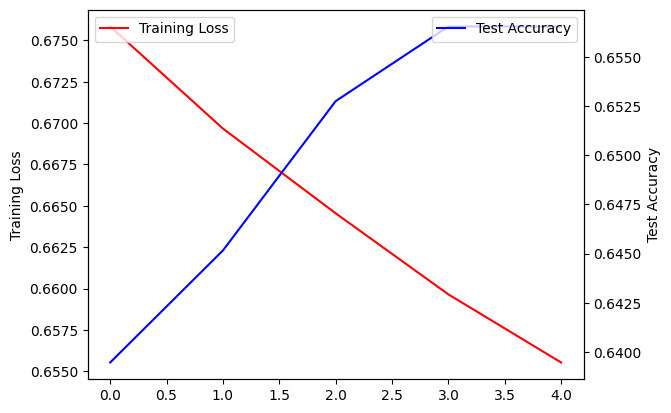

In [ ]:
# plot training loss and test accuracy, same graph but different y-axis, give them different colors and y axis labels. Make x axis integer
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(training_losses, label="Training Loss", color="red")
ax2.plot(test_accuracy, label="Test Accuracy", color="blue")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.set_ylabel("Training Loss")
ax2.set_ylabel("Test Accuracy")
ax1.set_xlabel("Epoch")
plt.show()
